In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [27]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [28]:
def plot_results(df, pred_key, ax, suptitle, error_key="None"):
    ax.set_title(suptitle)
    cmap = red_blue_cmap()
    if error_key == "None":
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                       size=error_key, size_norm = (0.1, 0.3), sizes=(10, 200),
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlabel(r"x$_1$", fontsize=14)
    ax.set_ylabel(r"x$_2$", fontsize=14)

    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.set_xticks([-20, 0, 20])
    ax.set_yticks([-20, 0, 20])
    ax.set_aspect('equal', adjustable='box')
    ax.minorticks_on()
    return ax


In [29]:
def predict_grid(model, x1_key, x2_key, device, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)

    truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df["Prediction"] = preds
    df["Truth"] = truth
    #Get softmax score for blue
    df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [30]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [31]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 1000, 2000, 3000, 4000, 5000]
patience = 15
load_ensemble_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = True
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"
testfile = "x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/{truthfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [32]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [33]:
model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model # Check that everything looks good

100%|██████████| 100/100 [00:00<00:00, 592.44it/s]


Text(0.5, 0.98, 'Number of datapoints: 0')

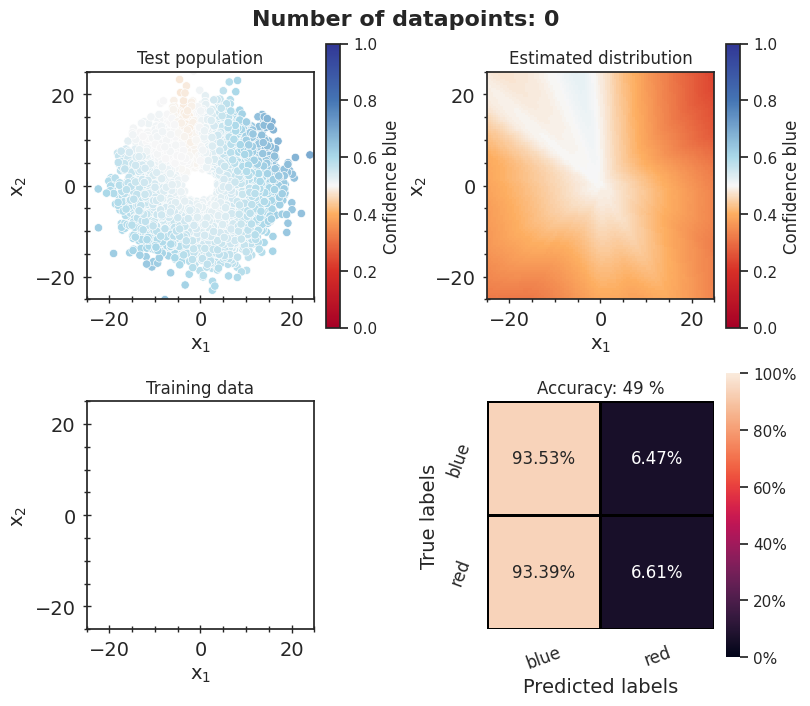

In [35]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test population")
axs[0][1] = plot_grid(grid_df, "Confidence", axs[0][1], "Estimated distribution")
axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[1][1])
axs[1][0] = plot_data(train_data[0:0], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

fig.suptitle(f"Number of datapoints: 0", size=16, fontweight="bold")

 55%|█████▌    | 22/40 [00:17<00:14,  1.26it/s]


Stopping training early at epoch 22


100%|██████████| 50/50 [00:00<00:00, 589.51it/s]


<Axes: xlabel='Iteration'>

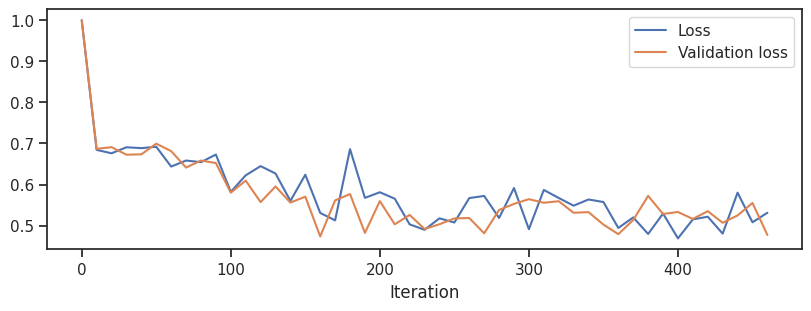

In [36]:
train_dataset = torch.utils.data.TensorDataset(X_train[0:5000], Y_train[0:5000])
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 40, 
                         device = device, optimizer = optimizer, early_stopping=patience)
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

100%|██████████| 100/100 [00:00<00:00, 599.45it/s]


Text(0.5, 0.98, 'Number of datapoints: 5000')

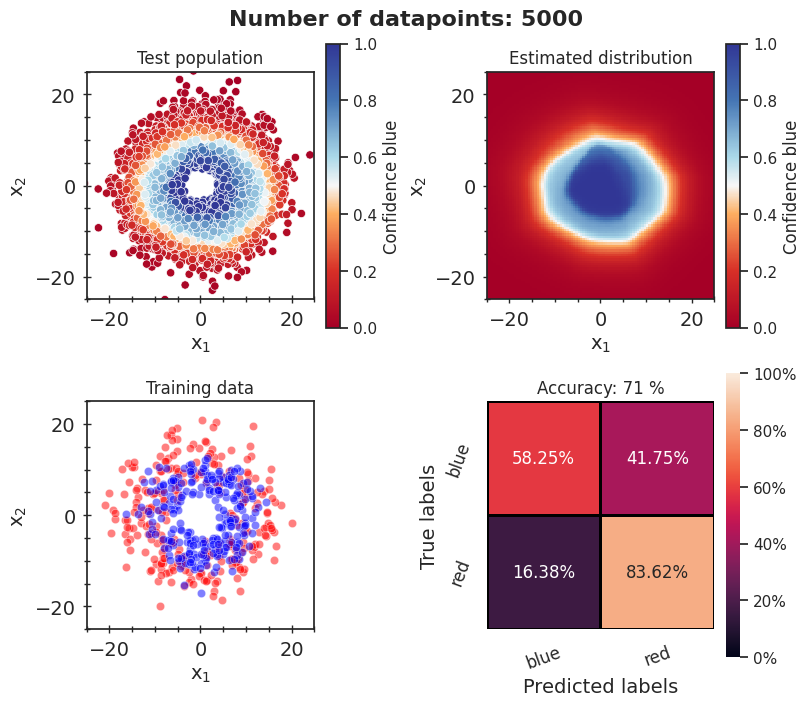

In [37]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test population")
axs[0][1] = plot_grid(grid_df, "Confidence", axs[0][1], "Estimated distribution")
axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[1][1])
axs[1][0] = plot_data(train_data[0:500], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

fig.suptitle(f"Number of datapoints: {len(train_dataset)}", size=16, fontweight="bold")

<Axes: xlabel='r_x', ylabel='Count'>

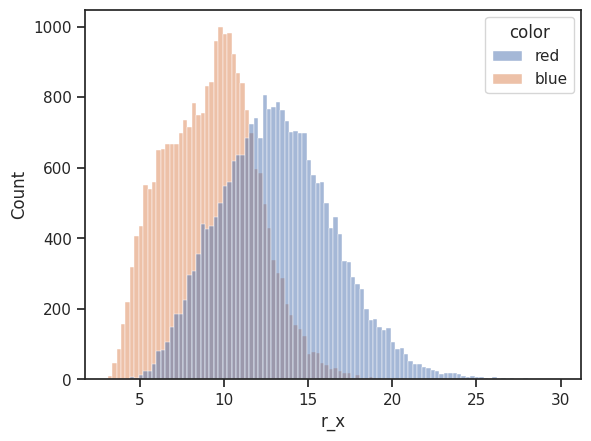

In [38]:
sn.histplot(train_data, x="r_x", hue="color")

/tmp/ipykernel_22183/1762824795.py:5: RuntimeWarning: invalid value encountered in scalar divide
  fraction_blue = np.array([(blue_count[i])/(red_count[i]+blue_count[i]) for i in range(len(red_count))])


Estimated maximum accuracy: 0.736054122215328


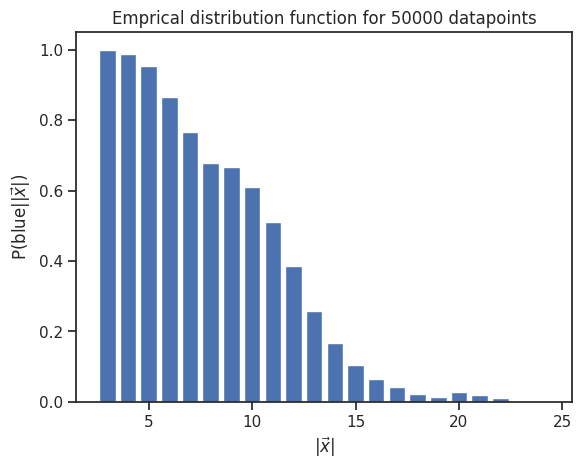

In [58]:
red_rx = train_data[train_data["color"] == "red"]["r_x"].values
blue_rx = train_data[train_data["color"] == "blue"]["r_x"].values
red_count, red_bins = np.histogram(red_rx, bins=25, range=(0, 25))
blue_count, blue_bins = np.histogram(blue_rx, bins=25, range=(0, 25))
fraction_blue = np.array([(blue_count[i])/(red_count[i]+blue_count[i]) for i in range(len(red_count))])
fraction_red = 1 - fraction_blue
plt.bar(red_bins[0:-1], fraction_blue)
plt.title(f"Emprical distribution function for {len(train_data)} datapoints")
plt.xlabel(r"$|\vec{x}|$")
plt.ylabel(r"P(blue||$\vec{x}$|)")
acc = np.array([max(fraction_blue[i], fraction_red[i])*(red_count[i]+blue_count[i])/sum(red_count + blue_count) for i in range(len(red_count))])
max_acc = sum(acc[~np.isnan(acc)])
print(f"Estimated maximum accuracy: {max_acc}")

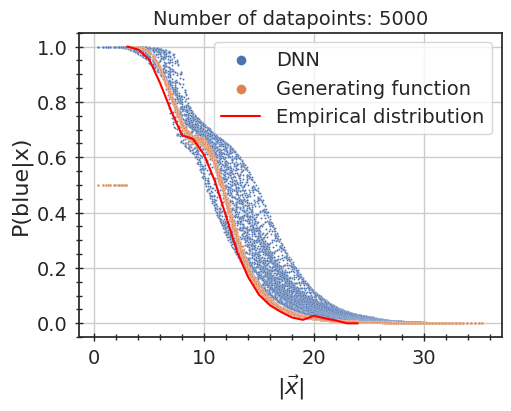

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
sn.scatterplot(grid_df, x="r_x", y="Confidence", s=2, ax = ax, label ="DNN")
sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
ax.plot(red_bins[0:-1], fraction, label="Empirical distribution", color="red")
ax.set_title(f"Number of datapoints: {len(train_dataset)}", fontsize=14)
ax.legend(markerscale=5, fontsize=14)
ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
ax.set_ylabel(r"P(blue|x)", fontsize=16)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
ax.tick_params(which="major", length=6)
ax.minorticks_on()
ax.grid()

<Axes: xlabel='Confidence', ylabel='Count'>

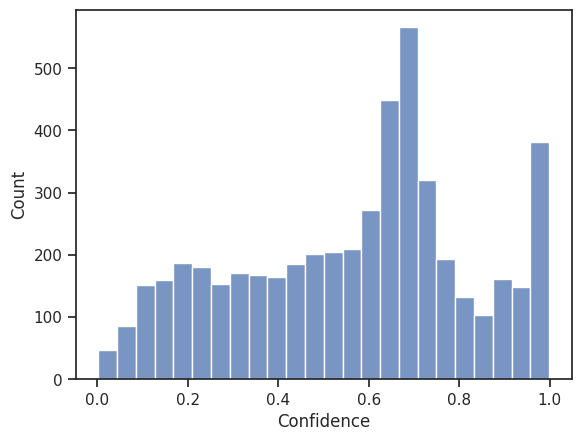

In [41]:
sn.histplot(val_data, x="Confidence")

 34%|███▍      | 24/70 [00:01<00:01, 23.58it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:03<00:07,  6.49it/s]


Stopping training early at epoch 24


 74%|███████▍  | 52/70 [00:31<00:10,  1.67it/s]


Stopping training early at epoch 52


 43%|████▎     | 30/70 [00:22<00:29,  1.33it/s]


Stopping training early at epoch 30


100%|██████████| 100/100 [00:00<00:00, 599.25it/s]


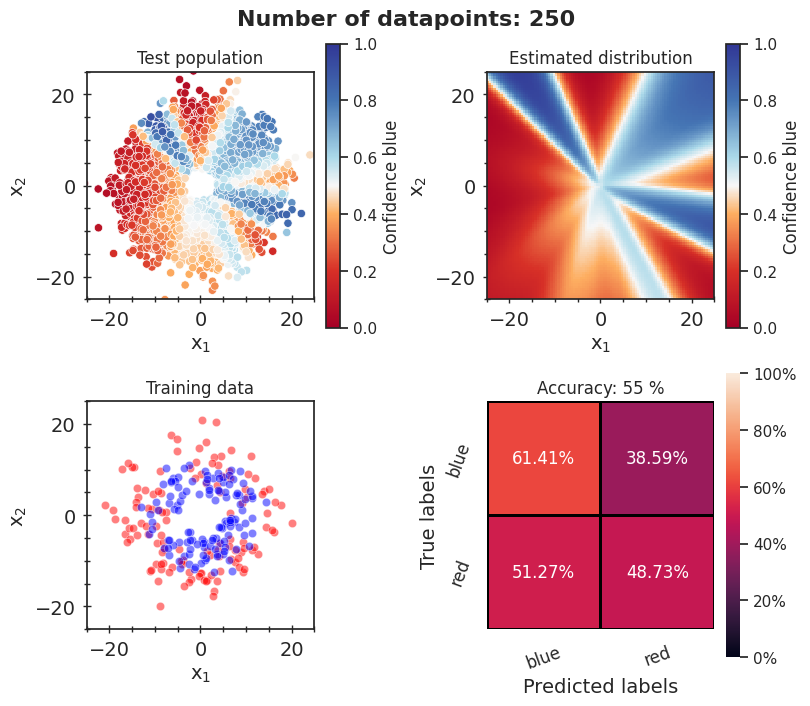

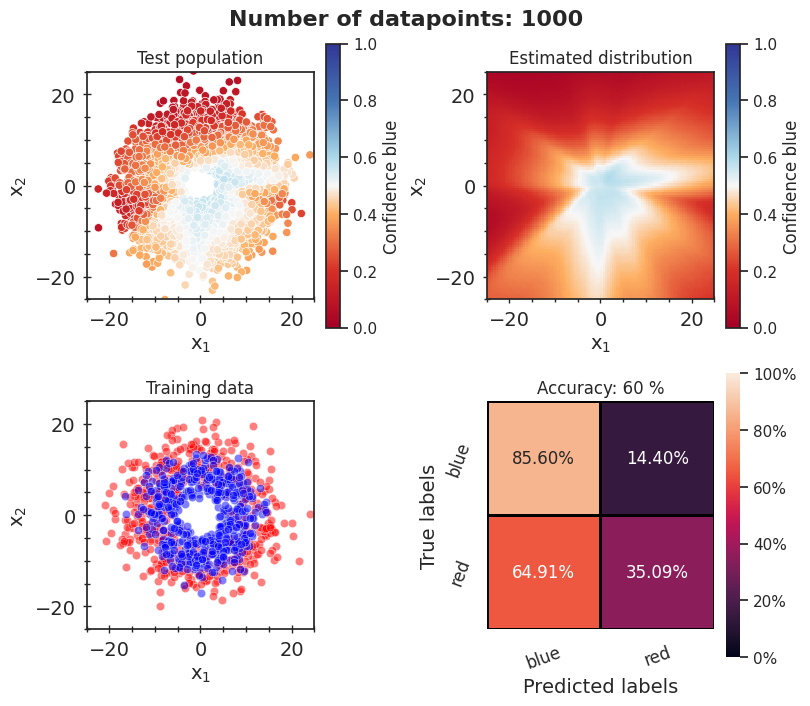

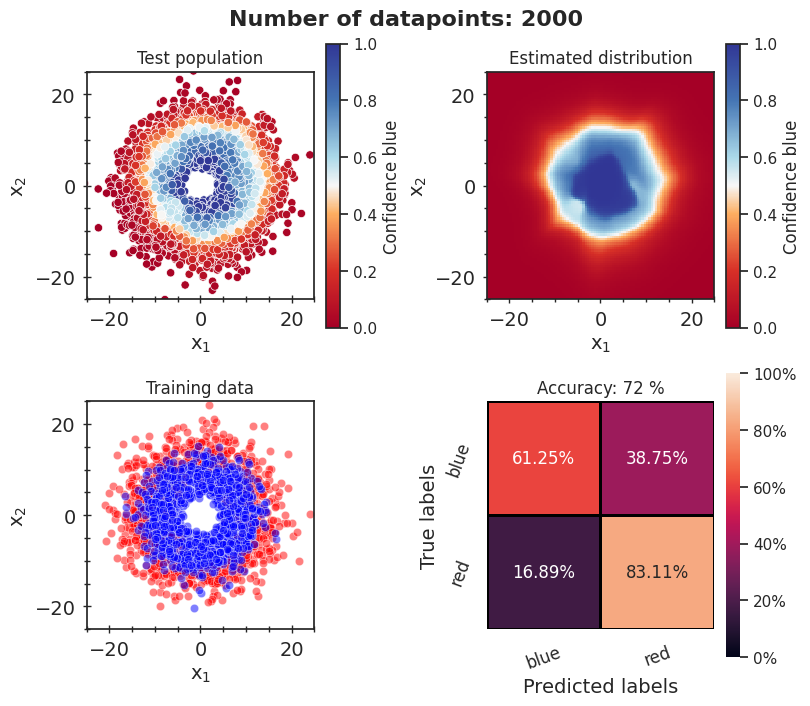

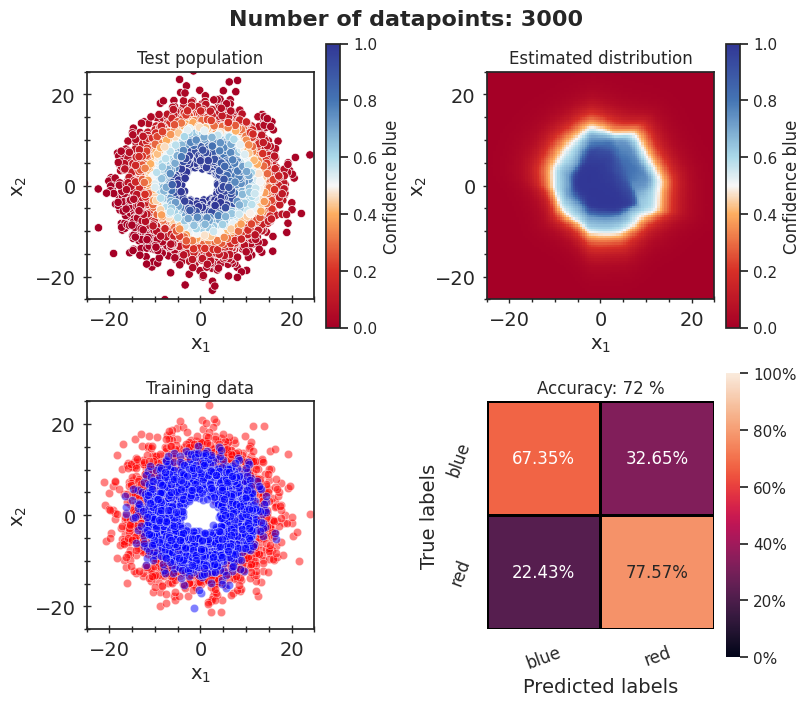

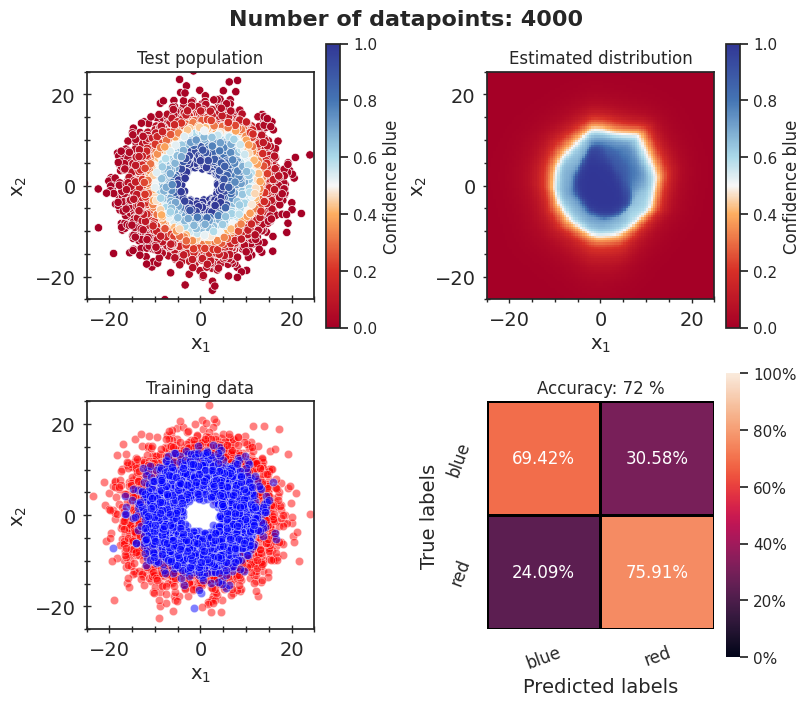

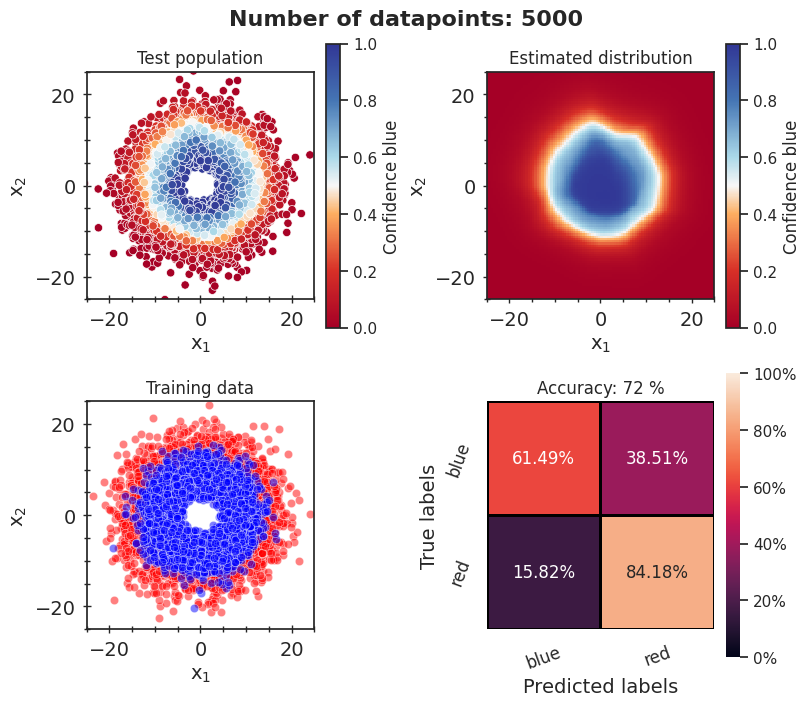

In [42]:

# Plot animation
#n_data = [10, 40, 80, 120, 150, 200, 250, 300, 500, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]

grid_dfs = [0]*len(n_data)

for i in range(len(n_data)):

    # Fresh validation dataframe
    val_data = pd.read_csv(f"../data/{valfile}.csv")
    val_data = word_to_int(val_data)

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data[i]], Y_train[0:n_data[i]])

    # Create new model
    model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    training_results = train_classifier(model, train_dataset, 
                            val_dataset, batchsize=2**9, epochs = 70, 
                            device = device, optimizer = optimizer, early_stopping=patience)
    
    # Predict on new model
    truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    val_data["Prediction"] = preds
    val_data["Truth"] = truth
    #Get softmax score for blue
    val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
    # Predict for grid
    grid_df = predict_grid(model, x1_key, x2_key, device)
    grid_dfs[i] = grid_df

    # Plot
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test population")
    axs[0][1] = plot_grid(grid_df, "Confidence", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {len(train_dataset)}", size=16, fontweight="bold")

    # Save plot
    #plt.savefig(f"../../fig/results/DNN/x1_x2_grid_{trainfile}_n_{n_data[i]}")

    # Save prediction
    #val_data.to_csv(f"predictions/{valfile}_predicted_SequentialNet_ndata-{n_data[i]}.csv")
    #grid_df.to_csv(f"predictions/grid_predicted_SequentialNet_ndata-{n_data[i]}.csv")

    # Save model
    #torch.save(model.state_dict(), f"models/{trainfile}_SequentialNet_ndata-{n_data[i]}.pt")

#plt.show()
    

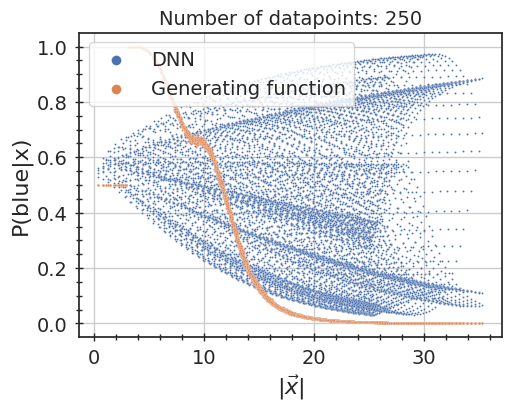

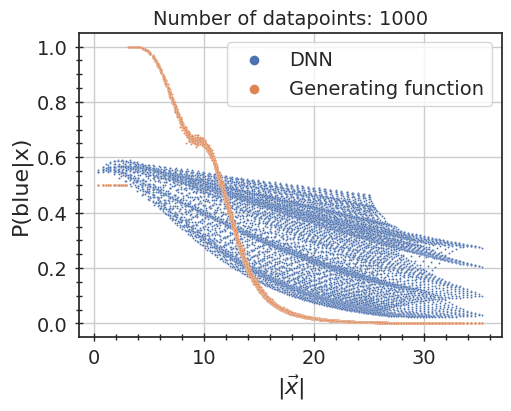

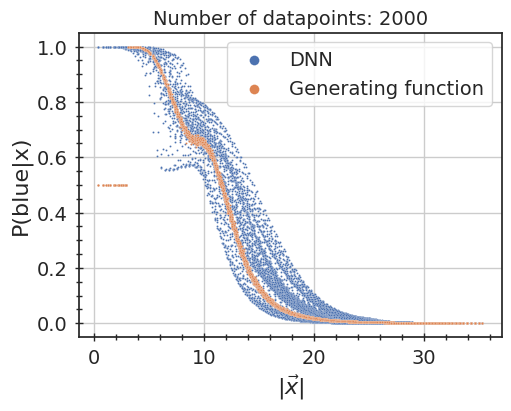

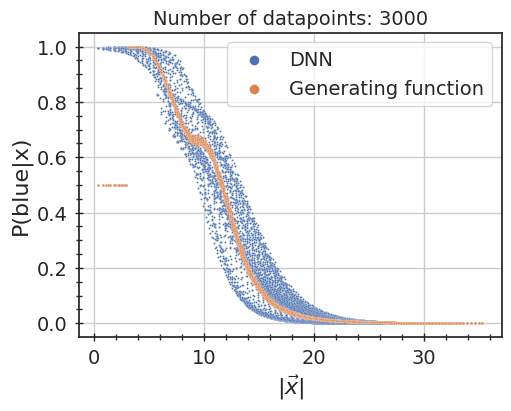

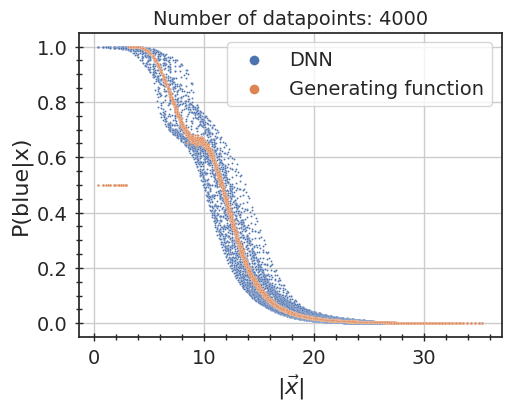

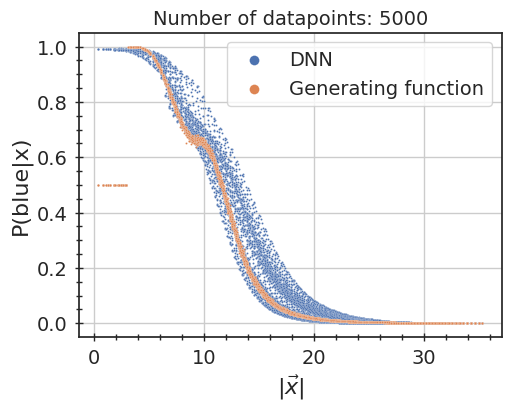

In [43]:

for i in range(len(n_data)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=2, ax = ax, label ="DNN")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
    ax.set_title(f"Number of datapoints: {n_data[i]}", fontsize=14)
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.set_ylabel(r"P(blue|x)", fontsize=16)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()



### Calibration

100%|██████████| 100/100 [00:00<00:00, 599.89it/s]


Text(0.5, 0.98, 'Number of datapoints: 5000')

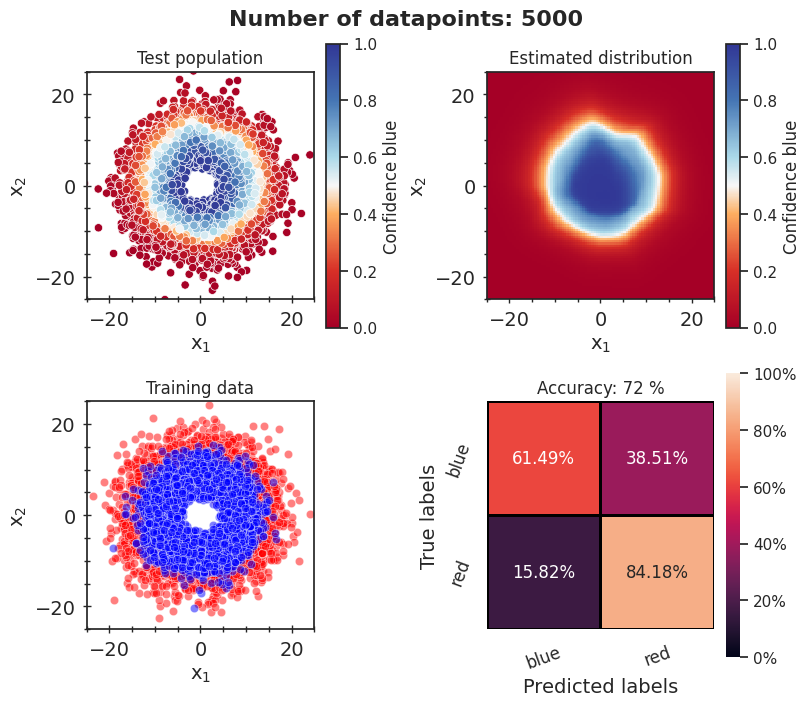

In [44]:

truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test population")
axs[0][1] = plot_grid(grid_df, "Confidence", axs[0][1], "Estimated distribution")
axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

fig.suptitle(f"Number of datapoints: {len(train_dataset)}", size=16, fontweight="bold")


In [45]:
val_data

color         x1         x2        a1        a2         r1  r2  \
0      red -10.685982   0.247318  3.107515  3.102613  13.685925   3   
1      red   6.517934  18.842814  1.225701  0.080292  16.946496   3   
2     blue  10.101325   7.399758  0.591001  0.172946   9.555816   3   
3     blue   6.168565   3.672720  0.340686  2.655884   9.694243   3   
4     blue  -6.823455  -6.068953  3.562035  1.977482   9.893021   3   
...    ...        ...        ...       ...       ...        ...  ..   
4995  blue  10.516936   4.502822  0.285772  0.468822   8.683448   3   
4996   red  11.995977 -10.837092  5.447627  2.568009  18.603909   3   
4997  blue  -2.321882  -5.453356  3.916992  2.283827   7.437896   3   
4998   red  13.664635   7.015536  0.412229  0.323295  12.486160   3   
4999   red  10.134063   3.073077  0.009755  1.702359  10.557108   3   

            r_x       a_x  class  Prediction  Truth  Confidence  
0     10.688843  3.118453      0           1    0.0    0.584934  
1     19.938283  1.237769      0           0    0.0    0.037635  
2     12.521709  0.632241      1           1    1.0    0.523116  
3      7.179141  0.537025      1           1    1.0    0.839721  
4      9.131907  3.868535      1           1    1.0    0.645564  
...         ...       ...    ...         ...    ...         ...  
4995  11.440339  0.404535      1           1    1.0    0.612494  
4996  16.166200  5.548498      0           0    0.0    0.085122  
4997   5.927076  4.309865      1           1    1.0    0.937824  
4998  15.360338  0.474317      0           0    0.0    0.237811  
4999  10.589761  0.294429      0           1    0.0    0.667323  

[5000 rows x 13 columns]

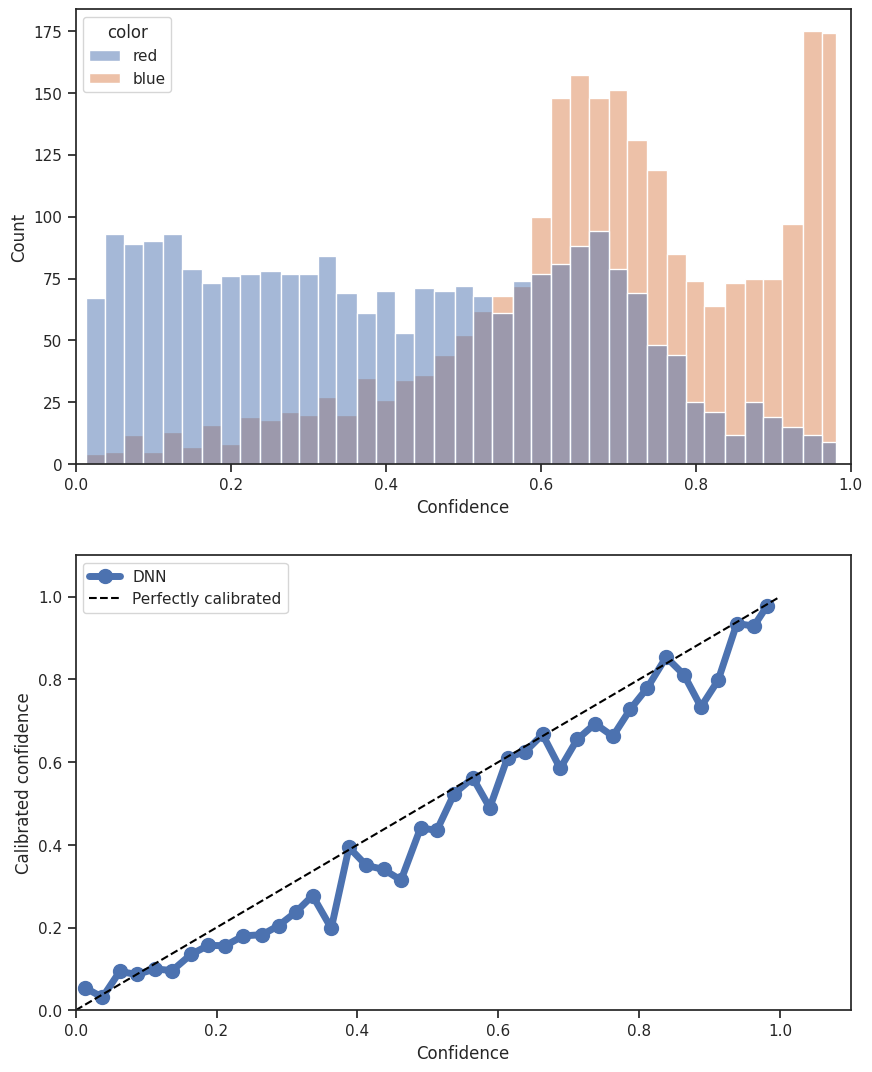

In [46]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

#Get confidence for red
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
prob_cal, prob_pred = calibration_curve(val_data["Truth"], val_data["Confidence"], n_bins=40, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
sn.histplot(val_data, x="Confidence", hue="color", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("Confidence")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()

## Ensembling

In [47]:

def train_ensemble(n_ensemble, n_data):
    val_data_ensembles = pd.read_csv(f"../data/{valfile}.csv")
    grid_ensembles = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))
    # Timer
    start = timer()
    print(f"Starting training of {n_ensemble} ensembles with {n_data} training points.")
    for i in range(n_ensemble):

        # Fresh validation dataframe
        val_data = pd.read_csv(f"../data/{valfile}.csv")
        val_data = word_to_int(val_data)

        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data], Y_train[0:n_data])

        # Create new model
        model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**9, epochs = 70, 
                                device = device, optimizer = optimizer, early_stopping=patience)
        
        # Predict on new model
        truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        val_data_ensembles[f"Prediction_{i}"] = preds
        val_data_ensembles["Truth"] = truth
        #Get softmax score for blue
        val_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits, dim=-1)[:,1]
        # Predict for grid
        grid_df = predict_grid(model, x1_key, x2_key, device)
        grid_ensembles[f"x1"] = grid_df["x1"]
        grid_ensembles[f"x2"] = grid_df["x2"]
        grid_ensembles[f"r_x"] = grid_df["r_x"]
        grid_ensembles[f"a_x"] = grid_df["a_x"]
        grid_ensembles[f"Confidence_{i}"] = grid_df["Confidence"]
    end = timer()
    print("Training time: ", timedelta(seconds=end-start))
    return val_data_ensembles, grid_ensembles

n_ensemble = 10

if load_ensemble_values==False:
    for i in range(len(n_data)):
        val_data_ensembles, grid_ensembles = train_ensemble(n_ensemble, n_data[i])
        val_data_ensembles["Confidence_avg"] = val_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        val_data_ensembles["Confidence_std"] = val_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        val_data_ensembles["Prediction_ensemble"] = 0
        mask = val_data_ensembles["Confidence_avg"] > 0.5
        val_data_ensembles.loc[mask, "Prediction_ensemble"] = 1
        grid_ensembles["Confidence_avg"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        grid_ensembles["Confidence_std"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        # Save prediction
        val_data_ensembles.to_csv(f"predictions/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
        grid_ensembles.to_csv(f"predictions/grid_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")

val_data_ensembles = [pd.read_csv(f"predictions/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
grid_ensembles = [pd.read_csv(f"predictions/grid_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]


Starting training of 10 ensembles with 250 training points.


  4%|▍         | 3/70 [00:00<00:02, 28.50it/s]

 49%|████▊     | 34/70 [00:01<00:01, 24.08it/s]


Stopping training early at epoch 34


 34%|███▍      | 24/70 [00:01<00:01, 24.00it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:01, 23.93it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:01, 23.99it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:01, 23.62it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:02, 18.07it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:01, 23.76it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:01, 23.73it/s]


Stopping training early at epoch 24


 34%|███▍      | 24/70 [00:01<00:01, 23.73it/s]


Stopping training early at epoch 24


 49%|████▊     | 34/70 [00:01<00:01, 23.85it/s]


Stopping training early at epoch 34


100%|██████████| 100/100 [00:00<00:00, 601.16it/s]


Training time:  0:00:14.286046
Starting training of 10 ensembles with 1000 training points.


 99%|█████████▊| 69/70 [00:10<00:00,  6.70it/s]


Stopping training early at epoch 69


 99%|█████████▊| 69/70 [00:10<00:00,  6.71it/s]


Stopping training early at epoch 69


 99%|█████████▊| 69/70 [00:10<00:00,  6.59it/s]


Stopping training early at epoch 69


 27%|██▋       | 19/70 [00:02<00:08,  6.37it/s]


Stopping training early at epoch 19


 99%|█████████▊| 69/70 [00:10<00:00,  6.63it/s]


Stopping training early at epoch 69


 84%|████████▍ | 59/70 [00:08<00:01,  6.60it/s]


Stopping training early at epoch 59


100%|██████████| 100/100 [00:00<00:00, 593.98it/s]


Training time:  0:01:38.505816
Starting training of 10 ensembles with 2000 training points.


 89%|████████▊ | 62/70 [00:18<00:02,  3.28it/s]


Stopping training early at epoch 62


 91%|█████████▏| 64/70 [00:19<00:01,  3.32it/s]


Stopping training early at epoch 64


 77%|███████▋  | 54/70 [00:16<00:04,  3.32it/s]


Stopping training early at epoch 54


 60%|██████    | 42/70 [00:12<00:08,  3.30it/s]


Stopping training early at epoch 42


 81%|████████▏ | 57/70 [00:16<00:03,  3.38it/s]


Stopping training early at epoch 57


 67%|██████▋   | 47/70 [00:14<00:06,  3.31it/s]


Stopping training early at epoch 47


 77%|███████▋  | 54/70 [00:16<00:04,  3.33it/s]


Stopping training early at epoch 54


 84%|████████▍ | 59/70 [00:17<00:03,  3.37it/s]


Stopping training early at epoch 59


 91%|█████████▏| 64/70 [00:19<00:01,  3.35it/s]


Stopping training early at epoch 64


 91%|█████████▏| 64/70 [00:19<00:01,  3.34it/s]


Stopping training early at epoch 64


100%|██████████| 100/100 [00:00<00:00, 601.90it/s]


Training time:  0:02:53.352191
Starting training of 10 ensembles with 3000 training points.


 56%|█████▌    | 39/70 [00:17<00:13,  2.24it/s]


Stopping training early at epoch 39


 83%|████████▎ | 58/70 [00:25<00:05,  2.24it/s]


Stopping training early at epoch 58


 83%|████████▎ | 58/70 [00:25<00:05,  2.24it/s]


Stopping training early at epoch 58


 63%|██████▎   | 44/70 [00:19<00:11,  2.22it/s]


Stopping training early at epoch 44


 59%|█████▊    | 41/70 [00:18<00:13,  2.21it/s]


Stopping training early at epoch 41


 63%|██████▎   | 44/70 [00:19<00:11,  2.22it/s]


Stopping training early at epoch 44


 97%|█████████▋| 68/70 [00:30<00:00,  2.25it/s]


Stopping training early at epoch 68


 69%|██████▊   | 48/70 [00:21<00:09,  2.23it/s]


Stopping training early at epoch 48


 83%|████████▎ | 58/70 [00:25<00:05,  2.24it/s]


Stopping training early at epoch 58


 54%|█████▍    | 38/70 [00:17<00:14,  2.21it/s]


Stopping training early at epoch 38


100%|██████████| 100/100 [00:00<00:00, 594.73it/s]


Training time:  0:03:45.439750
Starting training of 10 ensembles with 4000 training points.


 84%|████████▍ | 59/70 [00:35<00:06,  1.64it/s]


Stopping training early at epoch 59


 41%|████▏     | 29/70 [00:17<00:25,  1.63it/s]


Stopping training early at epoch 29


 56%|█████▌    | 39/70 [00:23<00:18,  1.63it/s]


Stopping training early at epoch 39


 73%|███████▎  | 51/70 [00:30<00:11,  1.65it/s]


Stopping training early at epoch 51


 60%|██████    | 42/70 [00:25<00:17,  1.64it/s]


Stopping training early at epoch 42


 67%|██████▋   | 47/70 [00:28<00:13,  1.64it/s]


Stopping training early at epoch 47


 69%|██████▊   | 48/70 [00:29<00:13,  1.64it/s]


Stopping training early at epoch 48


 63%|██████▎   | 44/70 [00:26<00:15,  1.64it/s]


Stopping training early at epoch 44


 67%|██████▋   | 47/70 [00:28<00:14,  1.63it/s]


Stopping training early at epoch 47


 66%|██████▌   | 46/70 [00:27<00:14,  1.67it/s]


Stopping training early at epoch 46


100%|██████████| 100/100 [00:00<00:00, 595.64it/s]


Training time:  0:04:38.188687
Starting training of 10 ensembles with 5000 training points.


 86%|████████▌ | 60/70 [00:44<00:07,  1.35it/s]


Stopping training early at epoch 60


 63%|██████▎   | 44/70 [00:33<00:19,  1.33it/s]


Stopping training early at epoch 44


 86%|████████▌ | 60/70 [00:44<00:07,  1.35it/s]


Stopping training early at epoch 60


 67%|██████▋   | 47/70 [00:35<00:17,  1.33it/s]


Stopping training early at epoch 47


 47%|████▋     | 33/70 [00:24<00:27,  1.32it/s]


Stopping training early at epoch 33


 56%|█████▌    | 39/70 [00:29<00:23,  1.33it/s]


Stopping training early at epoch 39


 57%|█████▋    | 40/70 [00:30<00:22,  1.33it/s]


Stopping training early at epoch 40


 63%|██████▎   | 44/70 [00:33<00:19,  1.31it/s]


Stopping training early at epoch 44


 57%|█████▋    | 40/70 [00:30<00:22,  1.31it/s]


Stopping training early at epoch 40


 77%|███████▋  | 54/70 [00:41<00:12,  1.32it/s]


Stopping training early at epoch 54


100%|██████████| 100/100 [00:00<00:00, 592.07it/s]


Training time:  0:05:49.969470


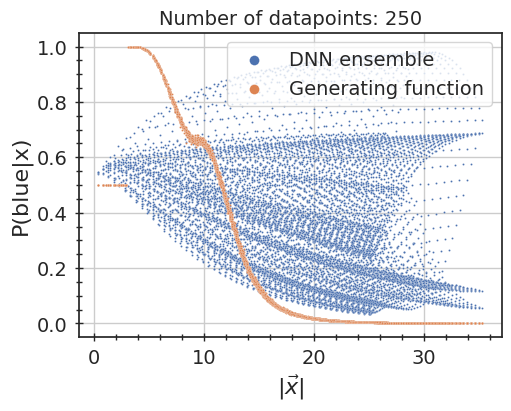

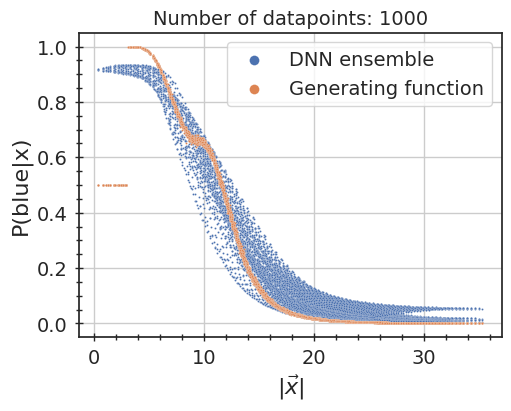

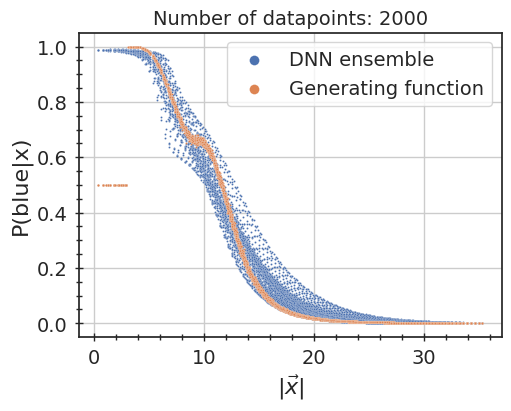

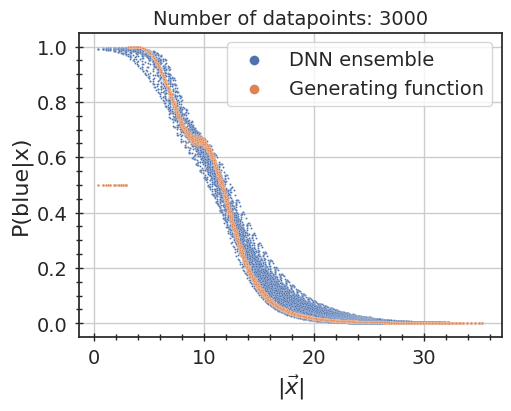

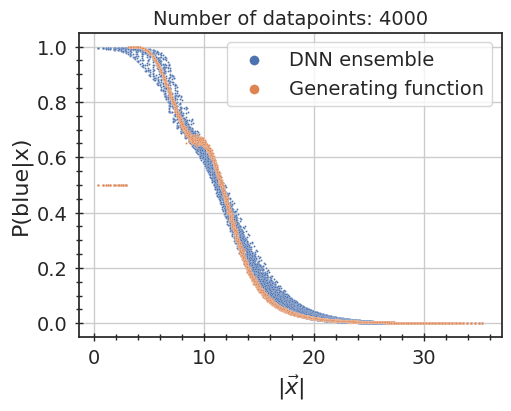

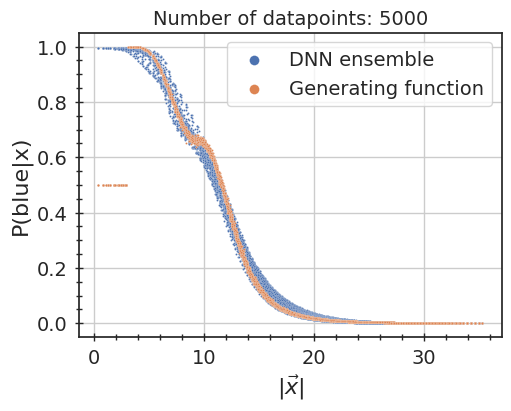

In [48]:
sn.set_theme(style="ticks")
for i in range(len(n_data)):
    fig, ax = plt.subplots(1, ncols=1, figsize= (5, 4), layout="constrained")
    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_avg", s=2, ax = ax, label ="DNN ensemble")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
    ax.set_title(f"Number of datapoints: {n_data[i]}", fontsize=14)
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.set_ylabel(r"P(blue|x)", fontsize=16)
    ax.grid(visible=True)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

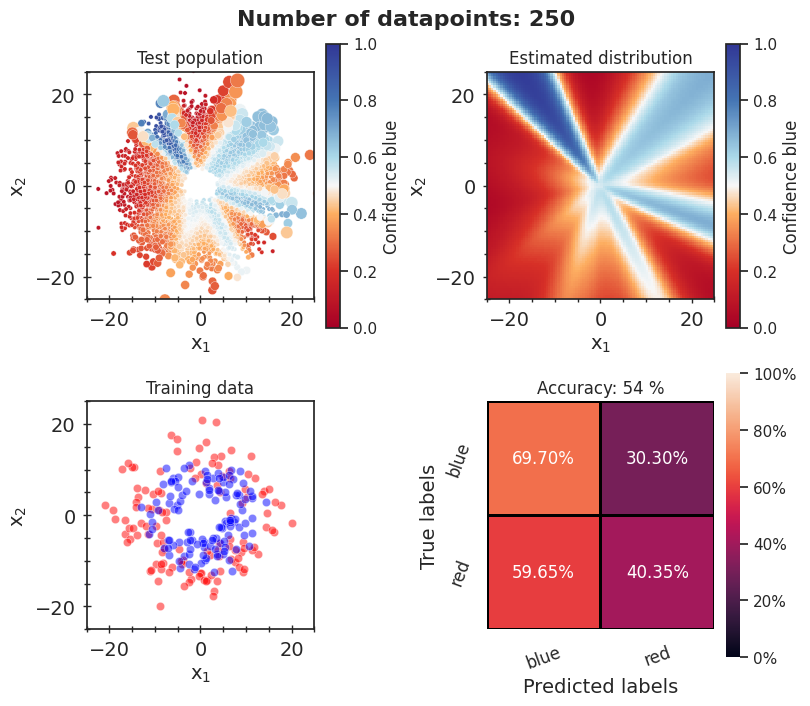

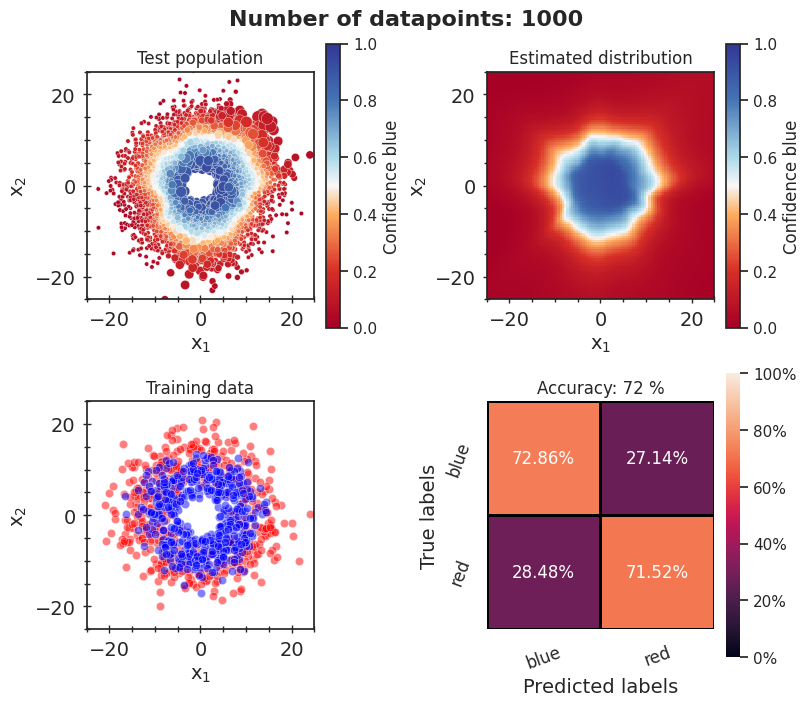

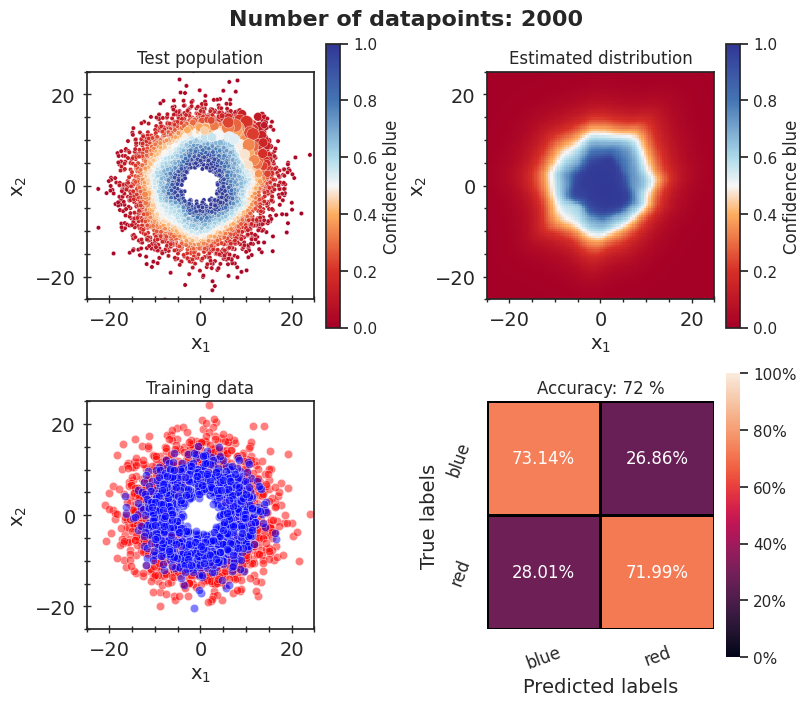

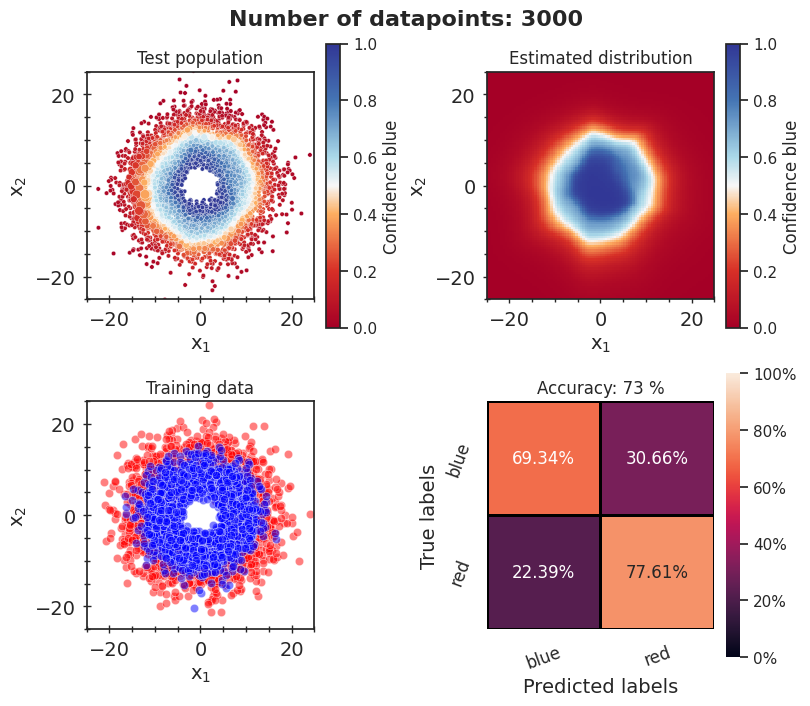

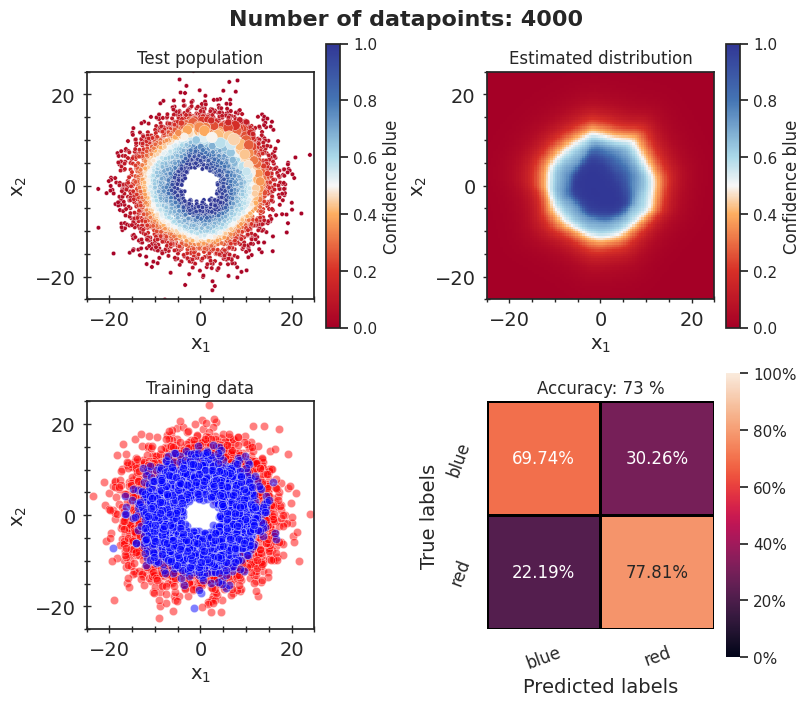

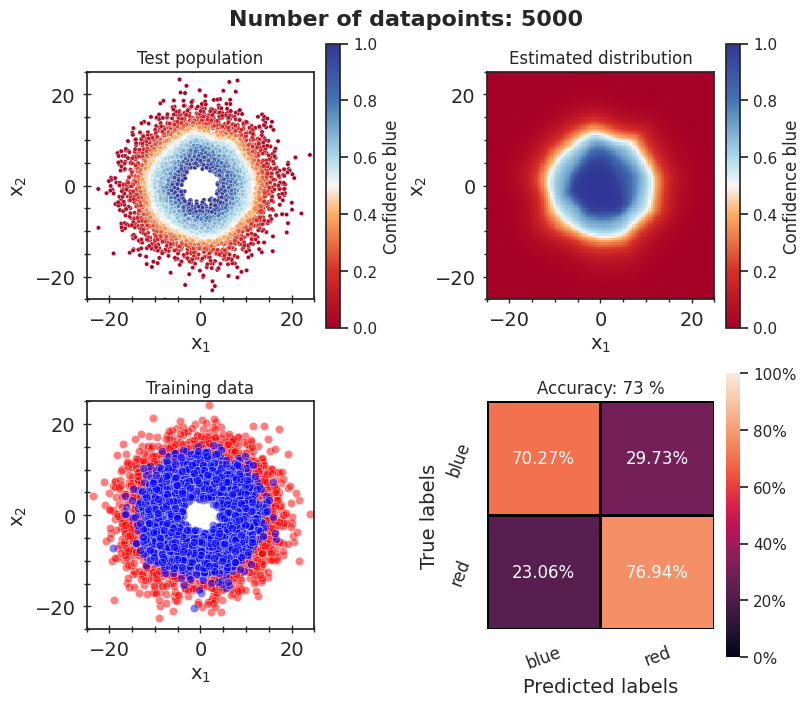

In [59]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_results(val_data_ensembles[i], "Confidence_avg", axs[0][0], "Test population", "Confidence_std")
    axs[0][1] = plot_grid(grid_ensembles[i], "Confidence_avg", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(val_data_ensembles[i], "Truth", "Prediction_ensemble", ["blue", "red"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")


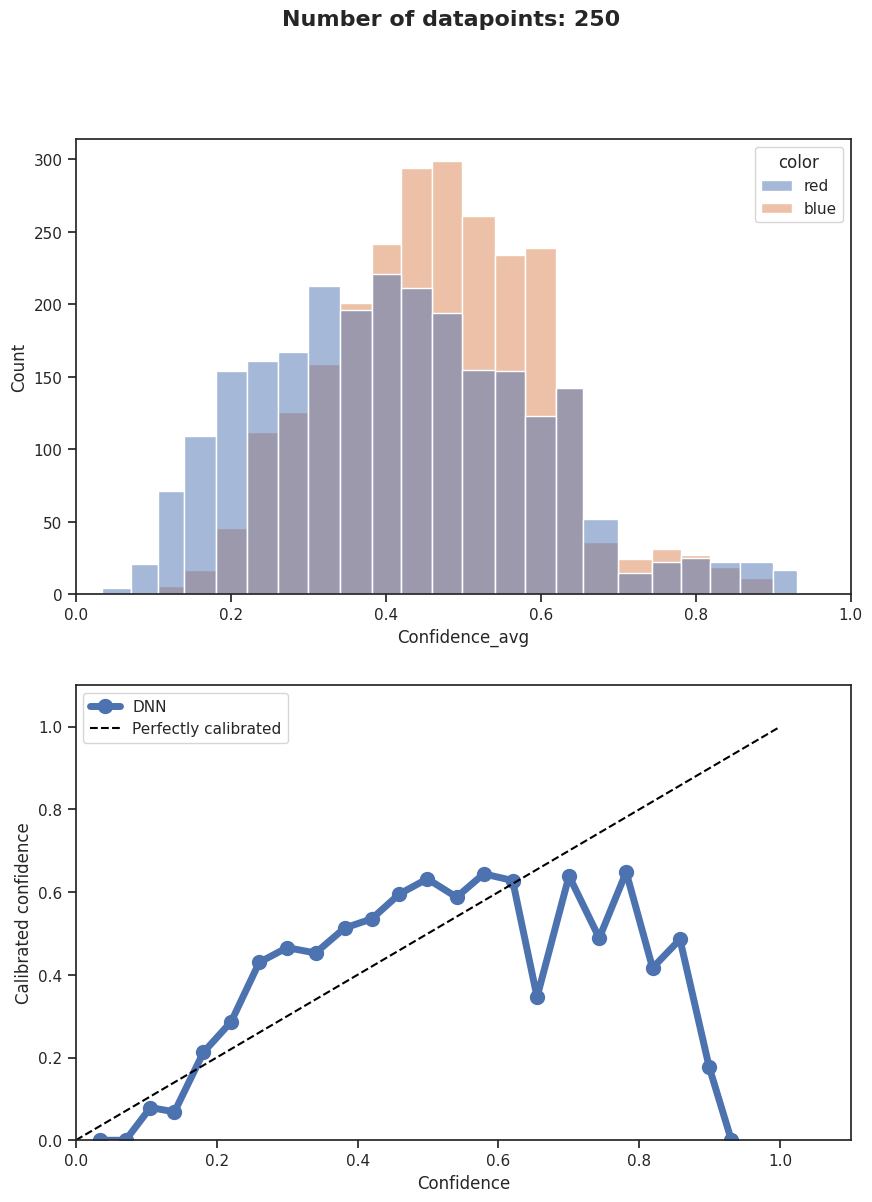

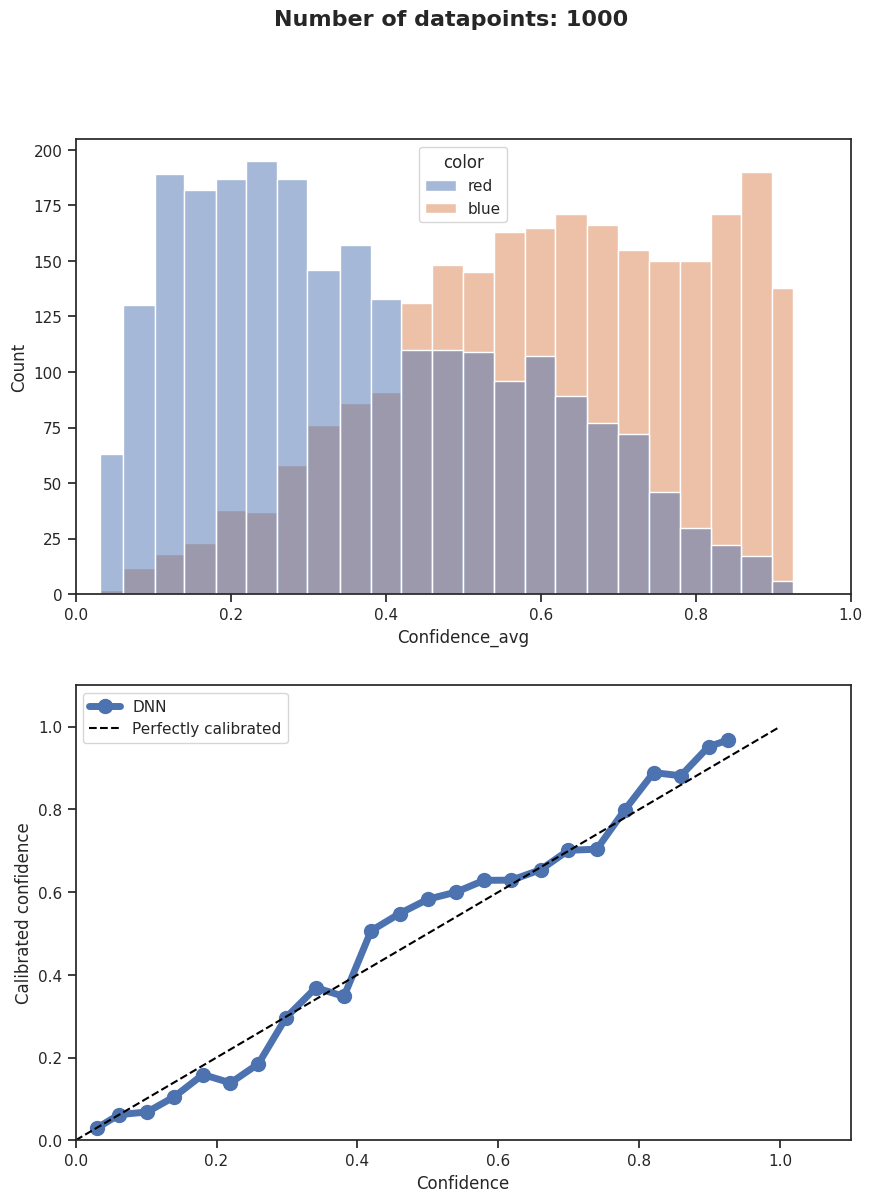

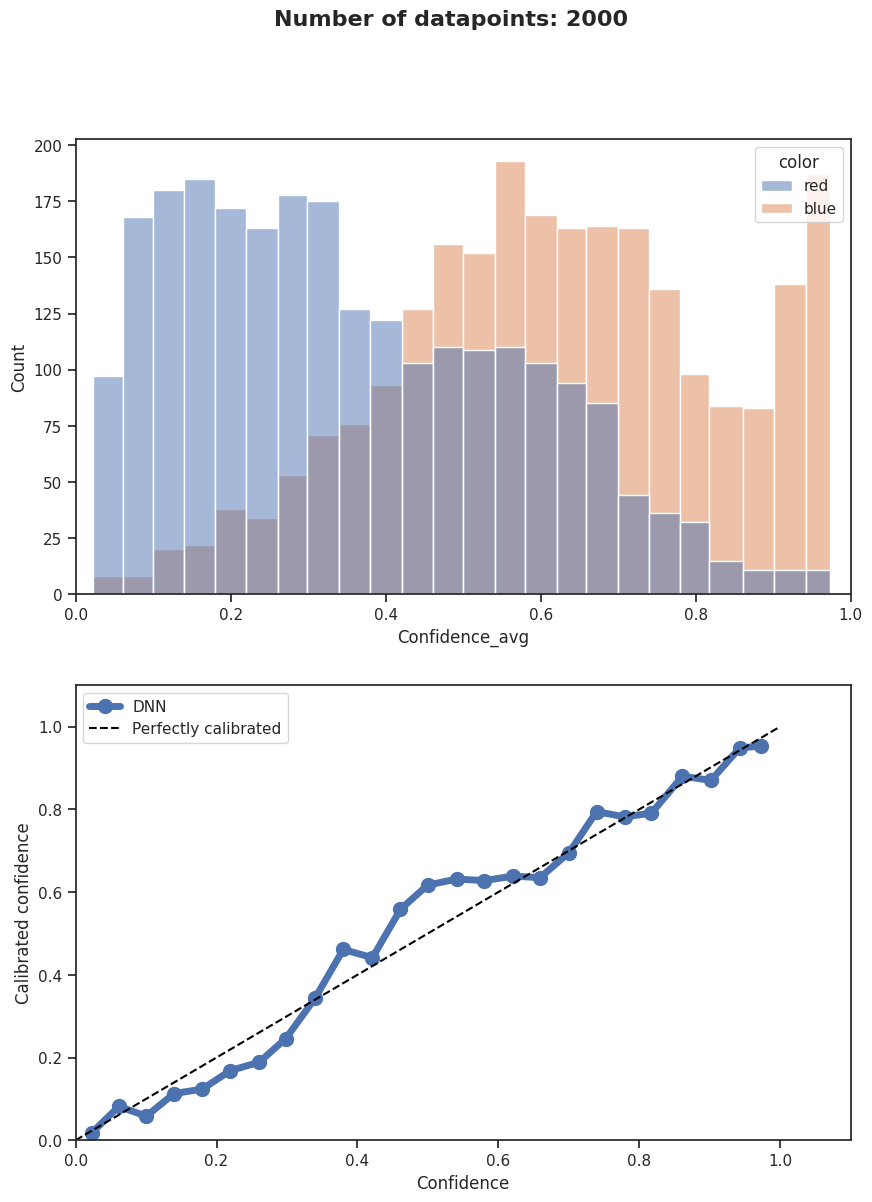

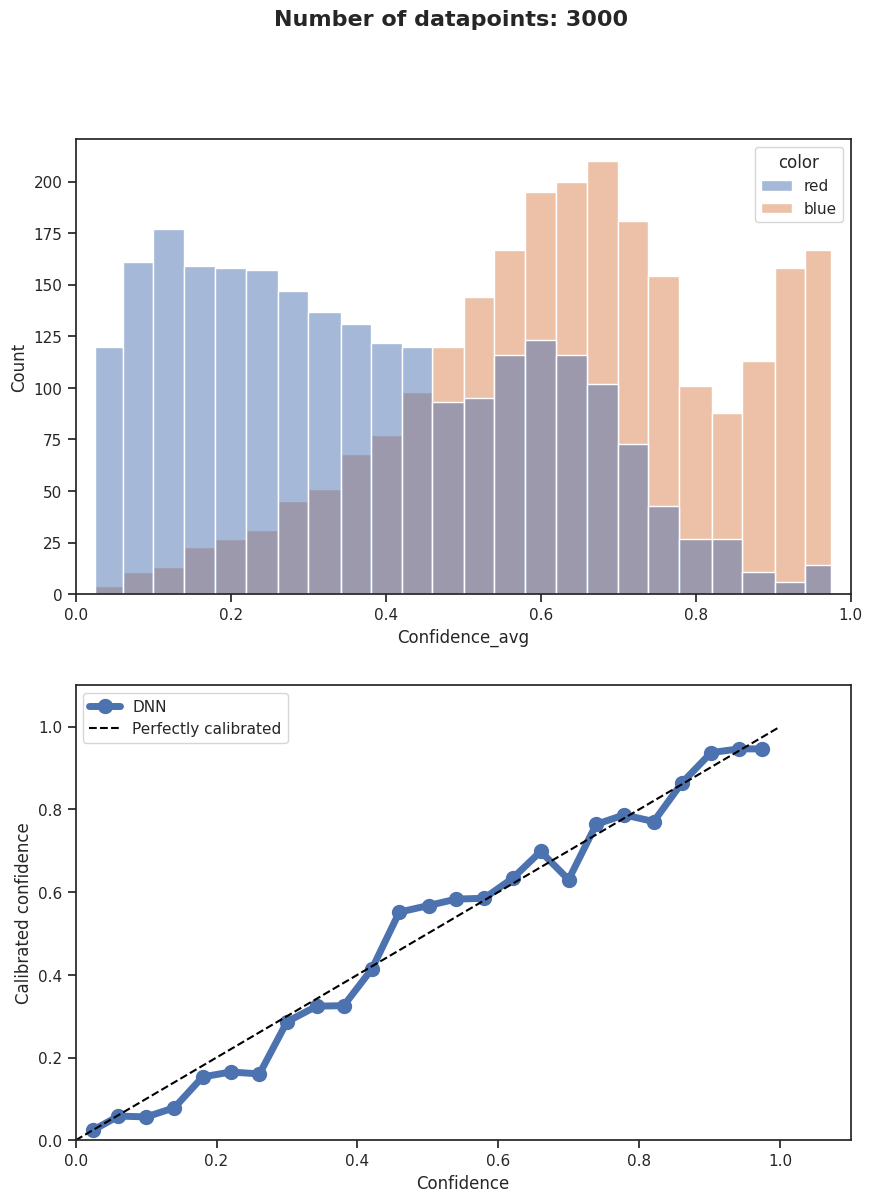

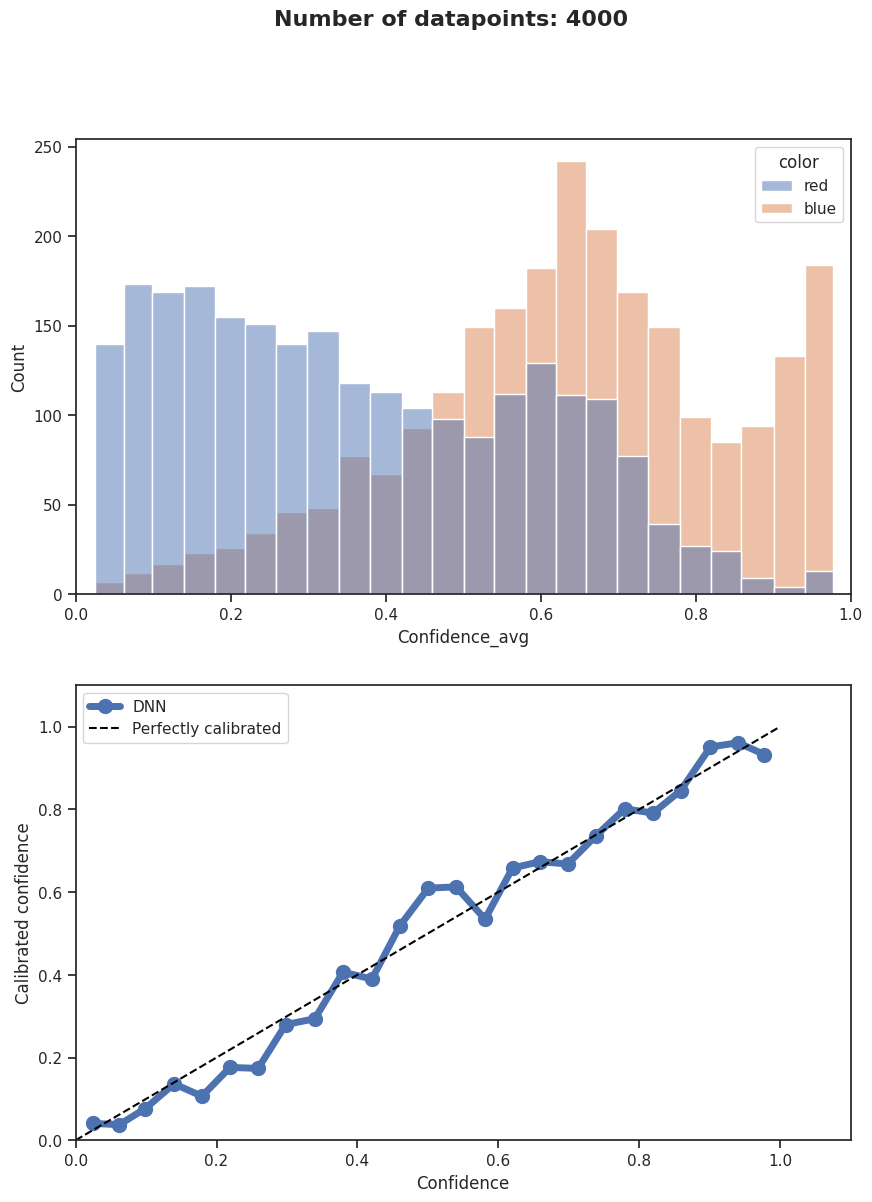

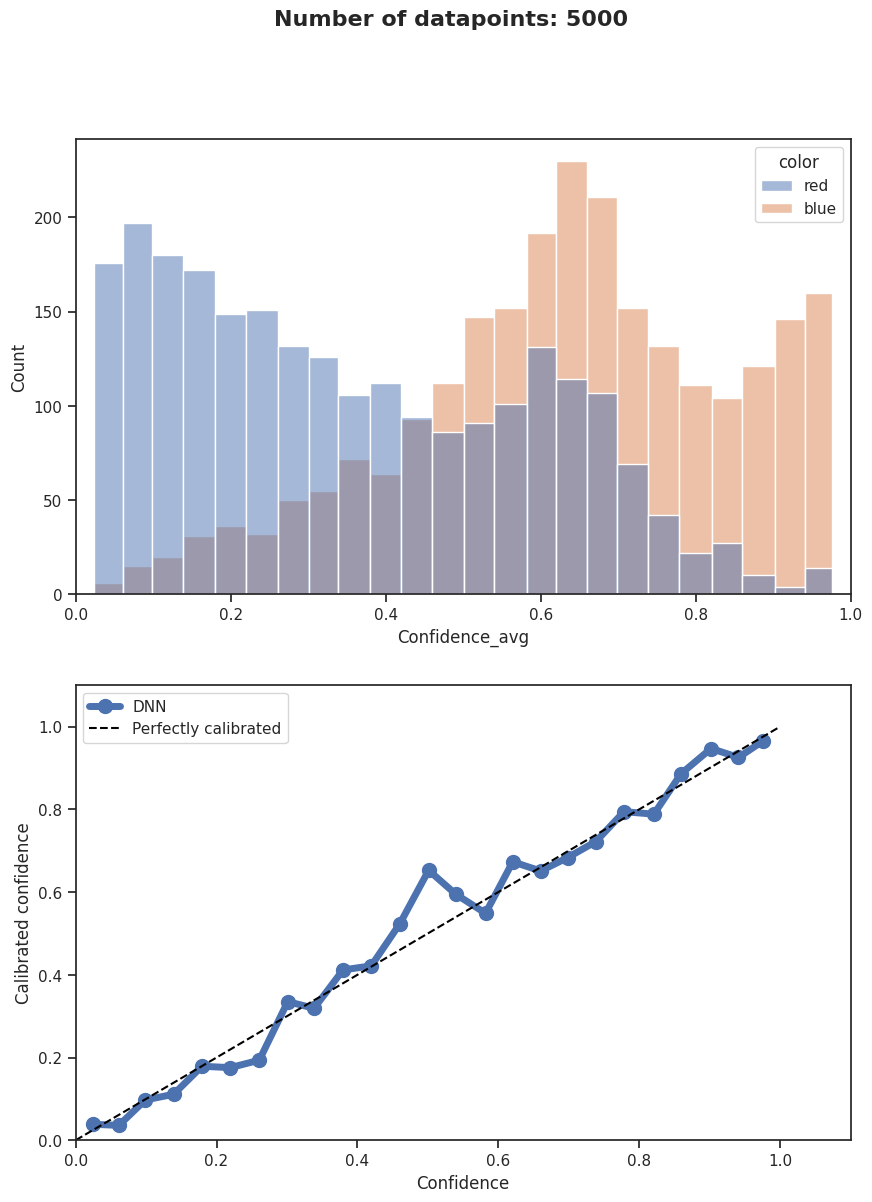

In [50]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

#Get confidence for red
for i in range(len(n_data)):
    df = val_data_ensembles[i]
    prob_cal, prob_pred = calibration_curve(df["Truth"], df["Confidence_avg"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
    sn.histplot(val_data_ensembles[i], x="Confidence_avg", hue="color", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("Confidence")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")